# Applying SVM classifier to Shalek2013

We're going to use the classifier knowledge that we've learned so far and apply it to the shalek2013 dataset.

In [7]:
# Alphabetical order is standard
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# Python plotting library
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Label processing
from sklearn import preprocessing

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Classification
from sklearn.svm import SVC


# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline


Utility functions for gene ontology and SVM decision boundary plotting

In [8]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
#Jake Vanderplass

## Read in the Shalek2013 data

In [9]:
metadata = pd.read_csv('../data/shalek2013/metadata.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression = pd.read_csv('../data/shalek2013/expression.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression_feature = pd.read_csv('../data/shalek2013/expression_feature.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)

expression = expression

# creating new column indicating color
metadata['color'] = metadata['maturity'].map(
    lambda x: 'MediumTurquoise' if x == 'immature' else 'Teal')
metadata.loc[metadata['pooled'], 'color'] = 'black'

# Create a column indicating both maturity and pooled for coloring with seaborn, e.g. sns.pairplot
metadata['group'] = metadata['maturity']
metadata.loc[metadata['pooled'], 'group'] = 'pooled'


metadata

,phenotype,pooled,outlier,maturity,color,group
S1,BDMC,False,False,immature,MediumTurquoise,immature
S2,BDMC,False,False,immature,MediumTurquoise,immature
S3,BDMC,False,False,immature,MediumTurquoise,immature
S4,BDMC,False,False,immature,MediumTurquoise,immature
S5,BDMC,False,False,immature,MediumTurquoise,immature
S6,BDMC,False,False,immature,MediumTurquoise,immature
S7,BDMC,False,False,immature,MediumTurquoise,immature
S8,BDMC,False,False,immature,MediumTurquoise,immature
S9,BDMC,False,False,immature,MediumTurquoise,immature
S10,BDMC,False,False,immature,MediumTurquoise,immature


### Side note: getting LPS response genes using `query`

Get the "LPS response genes" using a query:

In [10]:
print(expression_feature.shape)
expression_feature.head()

(27723, 1)


,gene_category
0610007L01RIK,NaN
0610007P14RIK,NaN
0610007P22RIK,NaN
0610008F07RIK,NaN
0610009B22RIK,NaN


In [11]:
expression_feature['gene_category'].unique()

array([nan, 'LPS Response', 'Housekeeping'], dtype=object)

In [12]:
# subset = expression_feature.query('gene_category == "Housekeeping"')
subset = expression_feature.query('gene_category == "LPS Response"')
subset.head(5)

,gene_category
1110018G07RIK,LPS Response
1110032F04RIK,LPS Response
1110038F14RIK,LPS Response
1190002H23RIK,LPS Response
1200009I06RIK,LPS Response


In [13]:
expression.head()

,NPL,QK,AK163153,PARK2,AGPAT4,IGF2R,MRPL18,TCP1,RNASEL,ACAT2,...,MIR692-1,RSPH3B,TAGAP1,RNASET2A,RPS6KA2,DHX9,RNASET2B,FGFR1OP,BRP44L,SFT2D1
S1,4.290577,5.038477,1.249363,0.540694,0.095072,2.648209,5.476280,5.711141,0.065396,4.138114,...,4.165290,0.705881,0.000000,4.700306,0.033376,0.573596,3.199527,0.000000,6.134085,3.699883
S2,0.000000,4.183371,1.947622,0.500426,5.868557,0.000000,0.000000,1.072934,0.000000,5.346876,...,3.646853,3.288222,0.000000,0.000000,1.061873,0.312905,1.060520,0.000000,6.715250,1.786313
S3,4.860293,3.847854,1.082463,0.604097,4.137252,3.350293,4.428491,4.795181,0.120361,0.184545,...,2.179880,2.155733,0.055715,0.313902,3.044962,0.223030,0.272703,0.154241,6.911104,0.000000
S4,0.090829,0.066797,1.119633,0.418703,0.066015,0.287966,5.351368,5.050281,0.099992,0.153751,...,3.476627,1.325198,4.680847,2.846205,3.190581,0.303179,0.000000,0.634990,7.116205,0.123292
S5,0.000000,3.305915,1.267464,0.000000,0.000000,0.000000,5.644345,5.809713,0.000000,3.807793,...,3.598966,0.505812,2.457638,1.172225,0.000000,0.038511,0.000000,4.883386,7.387554,4.569395


In [14]:
expression.iloc[0,:2] # row, col

NPL    4.290577
QK     5.038477
Name: S1, dtype: float64

Assign the variable `lps_response_genes` based on the gene ids pulled out from this subset:

In [15]:
lps_response_genes = subset.index #row names = genes, columns = samples / features
lps_response_genes
#expression feature data
#this times genes are samples
#and rows features
#e.g. whether TF
#e.g. whether LPS response

Index(['1110018G07RIK', '1110032F04RIK', '1110038F14RIK', '1190002H23RIK',
       '1200009I06RIK', '1600014C10RIK', '1810029B16RIK', '2010002M12RIK',
       '2200002D01RIK', '2210009G21RIK',
       ...
       'ZCCHC2', 'ZCCHC6', 'ZDHHC21', 'ZFP36', 'ZFP558', 'ZFP800', 'ZFP811',
       'ZHX2', 'ZNFX1', 'ZUFSP'],
      dtype='object', length=945)

In [16]:
who

FastICA	 PCA	 SVC	 expression	 expression_feature	 lps_response_genes	 metadata	 np	 pd	 
plot_svc_decision_function	 plt	 preprocessing	 sns	 subset	 


In [17]:
#above fails if any comment! shows all objects - special Jupyter keyword

For this analysis We want to compare the difference between the "mature" and "immature" cells in the Shalek2013 data.

In [18]:
singles_ids = [x for x in expression.index if x.startswith('S')]
singles = expression.loc[singles_ids]
singles.shape

(18, 6312)

Use only the genes that are substantially expressed in single cells

In [19]:
singles = singles.loc[:, (singles > 1).sum() >= 3]
print(singles.shape)
singles.tail()
# expression.tail()

(18, 6013)


,NPL,QK,AK163153,AGPAT4,IGF2R,MRPL18,TCP1,RNASEL,ACAT2,WTAP,...,MIR692-1,RSPH3B,TAGAP1,RNASET2A,RPS6KA2,DHX9,RNASET2B,FGFR1OP,BRP44L,SFT2D1
S14,0.099121,2.294456,1.110511,4.430612,0.703213,5.805900,5.127292,4.373110,4.634034,2.364453,...,3.708960,2.816471,0.353337,3.171981,0.598556,2.634747,4.574811,4.060312,7.261360,0.946980
S15,0.100920,0.301120,1.202271,0.000000,0.000000,0.280902,6.703530,0.000000,0.131139,0.120001,...,4.338427,0.000000,0.000000,1.249966,4.866136,0.203168,3.606193,3.981172,6.776869,0.000000
S16,0.206361,3.547688,4.446612,0.000000,0.599134,4.636011,4.934580,0.000000,0.072570,0.540513,...,3.304521,2.184800,0.338401,1.352671,3.314155,3.511727,3.200499,0.000000,4.288363,0.146869
S17,0.104884,2.185832,1.367261,4.219120,0.163095,0.156241,5.317671,0.000000,0.000000,0.507563,...,3.618070,2.465683,0.097507,0.747714,0.088512,0.579376,0.000000,0.000000,6.877628,5.181148
S18,0.000000,0.040923,0.428320,0.171028,2.456613,4.820447,4.619659,4.334508,0.107746,0.682873,...,2.627022,1.101847,0.094660,3.751406,1.075959,1.809603,1.431793,0.000000,6.542975,1.800422


Now because computers only understand numbers, we'll convert the category label of "mature" and "immature" into integers to a using a `LabelEncoder`. Let's look at that column again, only for mature cells:

In [20]:
singles_maturity = metadata.loc[singles.index, 'maturity']
singles_maturity

S1     immature
S2     immature
S3     immature
S4     immature
S5     immature
S6     immature
S7     immature
S8     immature
S9     immature
S10    immature
S11    immature
S12      mature
S13      mature
S14    immature
S15    immature
S16      mature
S17    immature
S18    immature
Name: maturity, dtype: object

In [21]:
# Instantiate the encoder
encoder = preprocessing.LabelEncoder() # from sklearn! much amaze!

# Get number of categories and transform "mature"/"immature" to numbers
target = encoder.fit_transform(singles_maturity)
# target = encoder.fit_transform([1,2,3,4,5,6,6,6,1,'a',2])
# target = encoder.fit_transform(['b','e','y','o','n','c','e']) # even matched alphanumeric order

target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])

## Run the classifier!!

Yay so now we can run a classifier!

In [22]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear')
classifier.fit(singles, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We'll use PCA or ICA to reduce our data for visualizing the SVM decision boundary. We'll only use two components for visualization so please don't change this to more components unless you like broken code!

In [23]:
n_components = 2

smusher = PCA(n_components=n_components)
smushed = pd.DataFrame(smusher.fit_transform(singles), index=singles.index)
print(smushed.shape)
smushed.head()

# Let's add the group identifier here for plotting:

smushed_with_group = smushed.join(metadata['group'])
print(smushed_with_group.shape)
smushed_with_group.head()

(18, 2)
(18, 3)


,0,1,group
S1,-50.895164,51.051727,immature
S2,-6.621843,-16.845237,immature
S3,-27.129347,-13.530018,immature
S4,-23.018061,-34.946561,immature
S5,-29.971542,-1.820914,immature


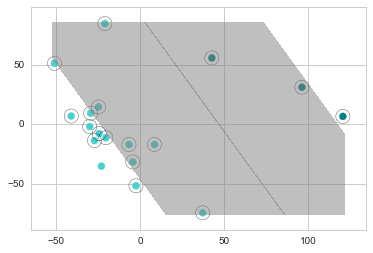

In [24]:
# Make a grid of the 2d PCA space
n_intervals = 50
x_min, x_max = smushed[0].min() - 1, smushed[0].max() + 1
y_min, y_max = smushed[1].min() - 1, smushed[1].max() + 1
X = np.linspace(x_min, x_max, n_intervals)
Y = np.linspace(y_min, y_max, n_intervals)
xx, yy = np.meshgrid(X, Y)
two_d_space = np.c_[xx.ravel(), yy.ravel()]

# Transform the two PCA space ot gene space
gene_space = smusher.inverse_transform(two_d_space)

# Get the decision boundary
Z = classifier.decision_function(gene_space)
Z = Z.reshape(xx.shape)

support_vectors_smushed = pd.DataFrame(smusher.transform(classifier.support_vectors_))

fig, ax = plt.subplots()

# ax.scatter(smushed_intervals[0], smushed_intervals[1], color='pink')
ax.scatter(smushed[0], smushed[1], color=metadata['color'], s=50)
ax.scatter(support_vectors_smushed[0], support_vectors_smushed[1], s=200, facecolors='none')
ax.contourf(X, Y, Z, colors='grey',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
#big margin is good
#all data in support vectors bad - most on boundary, very little completely in one group or other
#so change in one data point likely to change support vector - vulnerable to data, data not rich enough
#if fewer data points - can randomise data to try to learn more robust boundary for data set
#may be SVMs not appropriate and want to try decision trees for your kernel

In [25]:
n_components = 2

smusher = FastICA(n_components=n_components, max_iter=200, tol=0.002) #how much closer between two iterations
smushed = pd.DataFrame(smusher.fit_transform(singles), index=singles.index)
print(smushed.shape)
smushed.head()

# Let's add the group identifier here for plotting:

smushed_with_group = smushed.join(metadata['group'])
print(smushed_with_group.shape)
smushed_with_group.head()

(18, 2)
(18, 3)


,0,1,group
S1,-0.336338,0.245775,immature
S2,-0.007873,-0.110941,immature
S3,-0.117032,-0.116906,immature
S4,-0.063441,-0.241983,immature
S5,-0.149349,-0.049280,immature


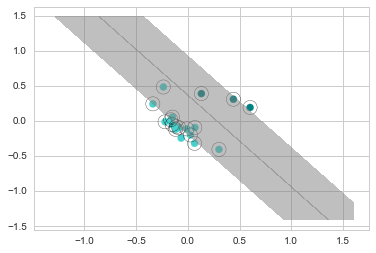

In [26]:
# Make a grid of the 2d PCA space
n_intervals = 50
x_min, x_max = smushed[0].min() - 1, smushed[0].max() + 1
y_min, y_max = smushed[1].min() - 1, smushed[1].max() + 1
X = np.linspace(x_min, x_max, n_intervals)
Y = np.linspace(y_min, y_max, n_intervals)
xx, yy = np.meshgrid(X, Y)
two_d_space = np.c_[xx.ravel(), yy.ravel()]

# Transform the two PCA space ot gene space
gene_space = smusher.inverse_transform(two_d_space)

# Get the decision boundary
Z = classifier.decision_function(gene_space)
Z = Z.reshape(xx.shape)

support_vectors_smushed = pd.DataFrame(smusher.transform(classifier.support_vectors_))

fig, ax = plt.subplots()

# ax.scatter(smushed_intervals[0], smushed_intervals[1], color='pink')
ax.scatter(smushed[0], smushed[1], color=metadata['color'], s=50)
ax.scatter(support_vectors_smushed[0], support_vectors_smushed[1], s=200, facecolors='none')
ax.contourf(X, Y, Z, colors='grey',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
#big margin is good
#all data in support vectors bad - most on boundary, very little completely in one group or other
#so change in one data point likely to change support vector - vulnerable to data, data not rich enough
#if fewer data points - can randomise data to try to learn more robust boundary for data set
#may be SVMs not appropriate and want to try decision trees for your kernel

In [53]:
expression_feature.head()

,gene_category
0610007L01RIK,NaN
0610007P14RIK,NaN
0610007P22RIK,NaN
0610008F07RIK,NaN
0610009B22RIK,NaN


In [52]:
subset = expression_feature.query('gene_category == "LPS Response"')
print(subset)
subset.head()

               gene_category
1110018G07RIK   LPS Response
1110032F04RIK   LPS Response
1110038F14RIK   LPS Response
1190002H23RIK   LPS Response
1200009I06RIK   LPS Response
1600014C10RIK   LPS Response
1810029B16RIK   LPS Response
2010002M12RIK   LPS Response
2200002D01RIK   LPS Response
2210009G21RIK   LPS Response
2310014L17RIK   LPS Response
2310042D19RIK   LPS Response
2810474O19RIK   LPS Response
3110001I22RIK   LPS Response
4921513D23RIK   LPS Response
4930523C07RIK   LPS Response
5730508B09RIK   LPS Response
6330409N04RIK   LPS Response
6330512M04RIK   LPS Response
9030425E11RIK   LPS Response
9030625A04RIK   LPS Response
9130014G24RIK   LPS Response
9130017N09RIK   LPS Response
9230105E10RIK   LPS Response
9430076C15RIK   LPS Response
9930111J21RIK1  LPS Response
9930111J21RIK2  LPS Response
A130040M12RIK   LPS Response
A430084P05RIK   LPS Response
A630001G21RIK   LPS Response
...                      ...
USP25           LPS Response
USP42           LPS Response
VCAM1         

,gene_category
1110018G07RIK,LPS Response
1110032F04RIK,LPS Response
1110038F14RIK,LPS Response
1190002H23RIK,LPS Response
1200009I06RIK,LPS Response


In [28]:
singles_lps_response = singles.loc[:,lps_response_genes]
print(singles_lps_response.shape)
singles_lps_response.head(20)

(18, 945)


,1110018G07RIK,1110032F04RIK,1110038F14RIK,1190002H23RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2010002M12RIK,2200002D01RIK,2210009G21RIK,...,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP558,ZFP800,ZFP811,ZHX2,ZNFX1,ZUFSP
S1,3.711442,NaN,0.000000,NaN,3.275468,0.000000,5.609305,NaN,NaN,0.000000,...,0.035344,3.042277,4.425735,4.092559,NaN,4.025124,NaN,0.779382,2.998800,0.000000
S2,4.361671,NaN,0.147643,NaN,0.000000,0.000000,5.478071,NaN,NaN,0.000000,...,2.251330,1.018315,4.955713,0.356008,NaN,4.297776,NaN,0.032569,3.091207,5.000843
S3,0.000000,NaN,3.737014,NaN,2.987093,0.063526,5.320993,NaN,NaN,0.000000,...,0.094925,0.126673,3.952273,1.956983,NaN,0.000000,NaN,0.000000,3.794063,2.928699
S4,2.719587,NaN,0.000000,NaN,0.045823,0.000000,0.488049,NaN,NaN,0.000000,...,0.137427,2.025546,4.193989,2.372572,NaN,0.121924,NaN,0.000000,0.230278,0.430168
S5,2.982073,NaN,0.000000,NaN,2.829152,0.000000,5.093188,NaN,NaN,0.000000,...,0.616401,0.000000,4.039816,0.000000,NaN,4.714087,NaN,1.565475,0.860254,4.866979
S6,0.000000,NaN,0.851146,NaN,1.016506,3.500878,6.097377,NaN,NaN,0.721829,...,3.635734,3.437551,3.687978,1.033553,NaN,3.110635,NaN,2.192246,3.108098,2.597904
S7,3.881965,NaN,1.628513,NaN,2.743949,0.000000,5.956346,NaN,NaN,0.000000,...,0.025485,0.000000,3.730004,3.654413,NaN,1.278290,NaN,0.000000,1.197472,2.694247
S8,3.034992,NaN,0.000000,NaN,3.948293,4.506814,7.140110,NaN,NaN,0.242281,...,0.526813,3.475191,4.001580,6.502297,NaN,0.179204,NaN,0.000000,2.762293,0.412426
S9,0.031110,NaN,4.911391,NaN,0.000000,0.000000,6.510856,NaN,NaN,4.080961,...,0.059599,0.471974,4.701420,5.403925,NaN,3.443843,NaN,0.000000,3.096213,0.231651
S10,0.000000,NaN,3.882599,NaN,3.372394,0.000000,6.745099,NaN,NaN,0.000000,...,0.843348,1.035731,4.664242,0.141537,NaN,5.477474,NaN,0.136784,0.017415,0.000000


In [29]:
singles_lps_response.dropna()

,1110018G07RIK,1110032F04RIK,1110038F14RIK,1190002H23RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2010002M12RIK,2200002D01RIK,2210009G21RIK,...,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP558,ZFP800,ZFP811,ZHX2,ZNFX1,ZUFSP


In [30]:
singles_lps_response_no_na = singles_lps_response.dropna(axis=1)
print(singles_lps_response_no_na.shape)
singles_lps_response_no_na.head()

(18, 616)


,1110018G07RIK,1110038F14RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2210009G21RIK,2810474O19RIK,3110001I22RIK,4921513D23RIK,4930523C07RIK,...,ZC3H12C,ZC3HAV1,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP800,ZHX2,ZNFX1,ZUFSP
S1,3.711442,0.000000,3.275468,0.000000,5.609305,0.0,0.000000,3.828860,1.314573,3.778275,...,3.972904,3.509979,0.035344,3.042277,4.425735,4.092559,4.025124,0.779382,2.998800,0.000000
S2,4.361671,0.147643,0.000000,0.000000,5.478071,0.0,3.407342,0.000000,1.531443,0.000000,...,4.794306,4.984262,2.251330,1.018315,4.955713,0.356008,4.297776,0.032569,3.091207,5.000843
S3,0.000000,3.737014,2.987093,0.063526,5.320993,0.0,3.372359,0.058163,1.105115,0.025043,...,4.882749,0.807258,0.094925,0.126673,3.952273,1.956983,0.000000,0.000000,3.794063,2.928699
S4,2.719587,0.000000,0.045823,0.000000,0.488049,0.0,5.127847,0.000000,2.303969,0.000000,...,4.833354,4.538699,0.137427,2.025546,4.193989,2.372572,0.121924,0.000000,0.230278,0.430168
S5,2.982073,0.000000,2.829152,0.000000,5.093188,0.0,0.065122,4.635671,1.015640,0.461296,...,4.446634,0.157178,0.616401,0.000000,4.039816,0.000000,4.714087,1.565475,0.860254,4.866979


In [31]:
singles_subset = singles_lps_response_no_na

In [32]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear') #kernel = 'rbf', 'linear'
classifier.fit(singles_subset, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
n_components = 2

smusher = PCA(n_components=n_components) #how much closer between two iterations
smushed = pd.DataFrame(smusher.fit_transform(singles_subset), index=singles_subset.index) #change index
print(smushed.shape)
smushed.head()

# Let's add the group identifier here for plotting:

smushed_with_group = smushed.join(metadata['group'])
print(smushed_with_group.shape)
smushed_with_group.head()

(18, 2)
(18, 3)


,0,1,group
S1,-12.913502,15.902866,immature
S2,-2.265198,15.856642,immature
S3,-9.779530,1.228335,immature
S4,-12.523614,-0.518538,immature
S5,-8.002136,7.384079,immature


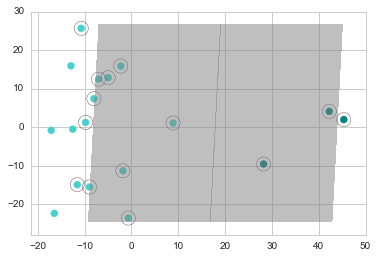

In [34]:
# Make a grid of the 2d PCA space
n_intervals = 50
x_min, x_max = smushed[0].min() - 1, smushed[0].max() + 1
y_min, y_max = smushed[1].min() - 1, smushed[1].max() + 1
X = np.linspace(x_min, x_max, n_intervals)
Y = np.linspace(y_min, y_max, n_intervals)
xx, yy = np.meshgrid(X, Y)
two_d_space = np.c_[xx.ravel(), yy.ravel()]

# Transform the two PCA space ot gene space
gene_space = smusher.inverse_transform(two_d_space)

# Get the decision boundary
Z = classifier.decision_function(gene_space)
Z = Z.reshape(xx.shape)

support_vectors_smushed = pd.DataFrame(smusher.transform(classifier.support_vectors_))

fig, ax = plt.subplots()

# ax.scatter(smushed_intervals[0], smushed_intervals[1], color='pink')
ax.scatter(smushed[0], smushed[1], color=metadata['color'], s=50)
ax.scatter(support_vectors_smushed[0], support_vectors_smushed[1], s=200, facecolors='none')
ax.contourf(X, Y, Z, colors='grey',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
#big margin is good
#all data in support vectors bad - most on boundary, very little completely in one group or other
#so change in one data point likely to change support vector - vulnerable to data, data not rich enough
#if fewer data points - can randomise data to try to learn more robust boundary for data set
#may be SVMs not appropriate and want to try decision trees for your kernel
# exact plot in paper - better but still - less is part of support vector so more robust, but data too sparse

That looks really cool! Almost ALL the data points are support vectors (except that one cell). Why do you think so?

### Exercise 1

1. Use an SVM classifier, but use ICA instead of PCA to visualize the decision boundary.
    1. How does that change the classification? class unchanged - classifier same, just visulasation changed
    2. Are the cells closer or farther from the decision boundary? ICA closer to boundaryIs that a "better" or "worse" classification? Why? Worse because less robust to changes in data / new data
    4. Why does the reduction algorithm affect the visualization of the classification? how much weight each gene contributes / principal components always the same
2. Could you use MDS or t-SNE for plotting of the classifier boundary? Why or why not? small data set
they use pairwise distances between all samples! Won't get the position in gene space - don't have a definition of where something is in tsne space - each point is invented point that may or may not exist in data - tSNE completely forgets what genes are there - just some distance between samples in whatever invented space - but there is no longer a mapping of this plane / cut of genes into tsne space - i.e. distance is dissimilarity metric!
3. Try the same analysis, but use the "LPS Response" genes and a dimensionality reduction algorithm of your choice. (... how do you subset only certain columns out of the dataframe?)
    1. How does that change the classification? 
    2. Are the cells closer or farther from the decision boundary? 
    3. Is that a "better" or "worse" classification? Why?
4. For (1) and (2) above, also fry using radial basis kernel (`kernel="rbf"`) for SVC.
    1. How does that change the classification? 
    2. Are the cells closer or farther from the decision boundary? 
    3. Is that a "better" or "worse" classification? Why?



This was nice but how do we *biologically* assess our classifiers? We want to do that using our biological knowledge of the data. Let's first look at the distribution of the coefficients in the data. This is the coefficient assigned to each feature. We'll first make it a Series so it's easy to work with (it's currently a numpy array).

In [35]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear') #kernel = 'rbf', 'linear'
classifier.fit(singles, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
coefficients = pd.Series(classifier.coef_.flat, index=singles.columns)
coefficients.head()

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/pandas/types/dtypes.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


NPL        -1.387786e-04
QK          1.543810e-04
AK163153    3.543145e-04
AGPAT4     -4.594230e-04
IGF2R       2.282964e-07
dtype: float64

Now let's plot the distribution of the coefficients across all featurs:

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


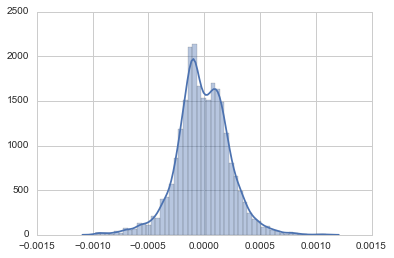

In [37]:
sns.distplot(coefficients)

This is semi-gaussian .. what does that mean? It means that most of the features in the dataset don't actually help you tell the difference between the datasets.

Let's get the features which are 2 std devs away from the mean of the data. Let's plot what that would look like

In [38]:
#most genes near 0
#x axis is how much genes influence decision boundary
#bimodality ok as really near zero - mild noise

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


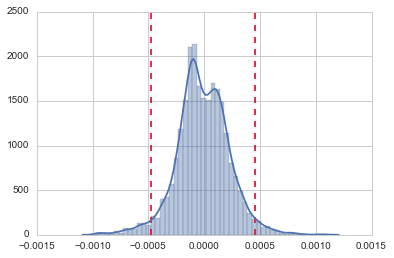

In [39]:
mean = coefficients.mean()
std = coefficients.std()
multiplier = 2 #typical cutoff for things that are gaussian
lower_cutoff = mean - multiplier * std
upper_cutoff = mean + multiplier * std

fig, ax = plt.subplots()
sns.distplot(coefficients)

# Add vertical lines
ymin, ymax = ax.get_ylim()
ax.vlines([lower_cutoff, upper_cutoff], ymin, ymax, linestyle='--', color='Crimson')

In [40]:
below_cutoff = coefficients[coefficients < lower_cutoff]
print(below_cutoff.shape)
below_cutoff.head()

(172,)


FPR1    -0.000507
FPR2    -0.000580
PRDX6   -0.000543
MYO1F   -0.000872
TNF     -0.000727
dtype: float64

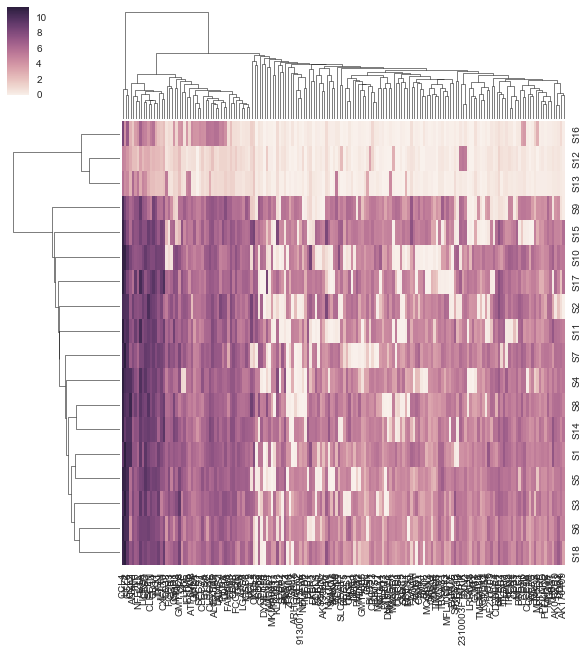

In [41]:
sns.clustermap(singles[below_cutoff.index])

Are these genes more expressed in the 3-cell mature population or the 15-cell immature population?

### Exercise 2

Get the genes that are *above* the cutoff and look at their clustered heatmap

In [42]:
# YOUR CODE HERE
above_cutoff = coefficients[coefficients > upper_cutoff]
print(above_cutoff.shape)
above_cutoff.head()

(153,)


RABGAP1L    0.000636
H2-OA       0.000502
H2-AA       0.000576
H2-Q7       0.000586
STAP2       0.000658
dtype: float64

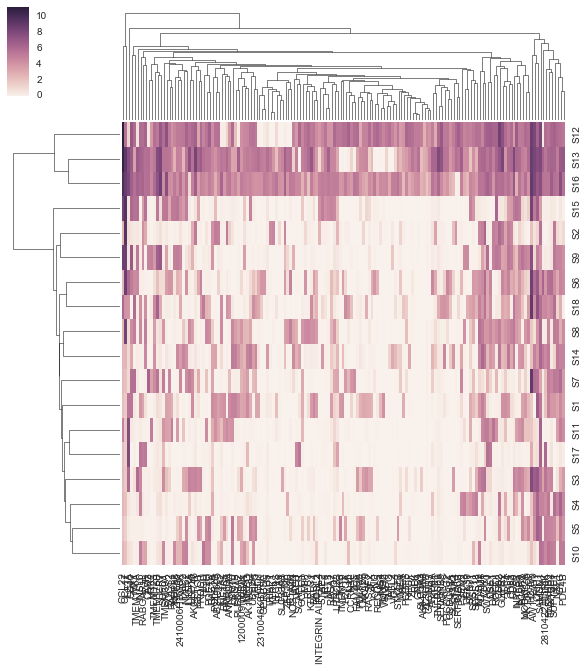

In [43]:
# YOUR CODE HERE
sns.clustermap(singles[above_cutoff.index])

In [56]:
print(above_cutoff.shape)
above_cutoff.head()

(153,)


RABGAP1L    0.000636
H2-OA       0.000502
H2-AA       0.000576
H2-Q7       0.000586
STAP2       0.000658
dtype: float64

In [102]:
combined_cutoffs = below_cutoff.index.union(above_cutoff.index)
print(combined_cutoffs.shape)
combined_cutoffs

(325,)


Index(['1200009I06RIK', '2310003F16RIK', '2310046K01RIK', '2410006H16RIK',
       '2810422J05RIK', '9130011J15RIK', 'AB349695', 'ACO1', 'ACP5', 'ACSL1',
       ...
       'VRK2', 'VSIG10', 'WBP5', 'ZC3H7B', 'ZEB1', 'ZFP180', 'ZFP655',
       'ZFP800', 'ZFX', 'ZWINT'],
      dtype='object', length=325)

In [100]:
good_genes = singles.loc[:,'NPL'] #row and column needed :,:
good_genes = singles.loc[:,combined_cutoffs] #
print(good_genes.shape)
good_genes

(18, 325)


,1200009I06RIK,2310003F16RIK,2310046K01RIK,2410006H16RIK,2810422J05RIK,9130011J15RIK,AB349695,ACO1,ACP5,ACSL1,...,VRK2,VSIG10,WBP5,ZC3H7B,ZEB1,ZFP180,ZFP655,ZFP800,ZFX,ZWINT
S1,3.275468,4.274800,0.084880,0.000000,2.034373,3.448202,3.516515,3.352800,7.340605,6.385660,...,0.000000,0.000000,4.760874,0.112042,0.065900,0.000000,0.845293,4.025124,2.650901,5.714924
S2,0.000000,5.346510,0.067445,0.655537,0.000000,0.188034,5.104356,0.032988,0.521307,0.357021,...,0.000000,0.083128,5.307864,0.113021,0.101811,0.000000,0.100499,4.297776,0.022029,4.575059
S3,2.987093,5.370662,0.000000,0.064808,5.550833,5.061562,0.080732,0.068521,4.676678,6.332812,...,0.073682,0.025551,5.589403,0.101362,0.000000,0.000000,0.094728,0.000000,3.220837,6.061260
S4,0.045823,5.531118,0.000000,0.173831,4.510556,0.238683,0.050548,0.056661,4.816804,5.326600,...,0.000000,0.031412,4.996919,0.060781,0.108364,2.824943,0.115565,0.121924,0.109410,2.378486
S5,2.829152,4.833759,0.000000,2.765989,5.000372,4.753810,0.000000,0.023480,5.824410,2.730261,...,0.073998,0.050708,5.322820,0.070925,0.037227,0.000000,1.556457,4.714087,0.000000,3.316937
S6,1.016506,5.625087,3.983571,2.433682,3.901860,4.616186,1.438619,2.833224,6.349134,3.434350,...,0.000000,0.031923,4.019600,0.061244,0.419044,0.831704,2.792260,3.110635,2.956172,3.039720
S7,2.743949,5.638285,0.061791,4.574354,2.206212,0.212097,0.053101,0.030186,6.252186,6.107253,...,3.424284,0.000000,6.558444,0.142059,0.000000,0.118524,0.110506,1.278290,0.000000,5.985126
S8,3.948293,4.893876,0.059396,0.000000,0.290879,0.086832,0.099579,0.162506,4.406075,5.241378,...,0.000000,0.031692,5.507910,0.189923,0.089833,3.775253,0.106332,0.179204,0.000000,6.330788
S9,0.000000,6.013836,0.073132,4.794223,0.349699,5.134333,0.374557,0.167456,4.187971,4.652192,...,4.959916,0.000000,3.793638,0.144446,0.056630,1.161901,5.171377,3.443843,0.000000,5.070816
S10,3.372394,4.532494,0.060106,2.675643,4.684618,5.372135,1.364288,0.085354,5.338623,8.023570,...,0.000000,0.032008,6.182151,0.000000,0.046429,0.039884,2.662417,5.477474,0.019517,0.262825


In [101]:
# YOUR CODE HERE
gg = pd.Series(good_genes.columns)
gg.to_csv('good_genes.csv', index=False)
gg

0      1200009I06RIK
1      2310003F16RIK
2      2310046K01RIK
3      2410006H16RIK
4      2810422J05RIK
5      9130011J15RIK
6           AB349695
7               ACO1
8               ACP5
9              ACSL1
10             ADAM8
11          AF251705
12          AK041408
13          AK041746
14          AK042010
15          AK139607
16          AK150559
17          AK170409
18          AK197782
19             AKAP9
20             ALAS1
21           ALOX5AP
22           ANKRD44
23             ANXA1
24             ANXA6
25              AOAH
26              APRT
27          ARHGAP15
28            ARID4A
29             ARL4C
           ...      
295         TMEM176A
296         TMEM176B
297           TMEM19
298          TMEM39A
299             TMPO
300            TMUB2
301             TMX1
302              TNF
303          TNFRSF9
304            TPD52
305            TREM2
306           TRIAP1
307           TRIM13
308             TXN2
309            UBE2H
310             UPP1
311          